#### Import the relevant libraries

In [3]:
from PIL import Image
from PIL import ImageFilter
from PIL import ImageDraw
import numpy as np
import copy
import time
import math

#### Read and convert to greyscale

Open the image and convert it to greyscale since we are asked to convolve on greyscale images

In [16]:
def display_np(x):
    """
    Display a numpy array as an image
    """
    result = Image.fromarray(x.astype('uint8'))
    result.show()

In [17]:
def read_image(x):
    x = Image.open('test-images/' + x).convert("L")
    x = np.array(x)
    return x

In [18]:
def read_list(imgs):
    return [read_image(im) for im in imgs]

In [19]:
pixels = read_image('music1.png')
# pixels.shape

#### Custom kernels

In [6]:
def check_range(x): return (np.min(x), np.max(x))

In [7]:
check_range(pixels)

(0, 255)

**Some test kernels**

- a = identity
- b = box blur
- c = horizontal derivative
- d = gaussian
- e = sharpening
- f = derivative of gaussian

In [8]:
a = np.zeros((3,3))
a[1,1] = 1
a

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [9]:
b = np.ones((3,3))
b

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [10]:
c = np.zeros((3,3))
c[1,0], c[1,2] = -1, 1
c

array([[ 0.,  0.,  0.],
       [-1.,  0.,  1.],
       [ 0.,  0.,  0.]])

In [11]:
d = np.array([[0.003,0.013,0.022,0.013,0.003],
             [0.013,0.059,0.097,0.059,0.013],
             [0.022,0.097,0.159,0.097,0.022],
             [0.013,0.059,0.097,0.059,0.013],
             [0.003,0.013,0.022,0.013,0.003]])
d

array([[0.003, 0.013, 0.022, 0.013, 0.003],
       [0.013, 0.059, 0.097, 0.059, 0.013],
       [0.022, 0.097, 0.159, 0.097, 0.022],
       [0.013, 0.059, 0.097, 0.059, 0.013],
       [0.003, 0.013, 0.022, 0.013, 0.003]])

In [12]:
# vary the value of alpha
e = np.zeros((5,5))
e[1:4,1:4] = a
alpha = 0.8 + 1
e = e * alpha - d
e

array([[-0.003, -0.013, -0.022, -0.013, -0.003],
       [-0.013, -0.059, -0.097, -0.059, -0.013],
       [-0.022, -0.097,  1.641, -0.097, -0.022],
       [-0.013, -0.059, -0.097, -0.059, -0.013],
       [-0.003, -0.013, -0.022, -0.013, -0.003]])

In [13]:
f = np.zeros((5,5))
f[1:4,1:4] = c
f = f * d
f

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.097,  0.   ,  0.097,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

#### Padding the image

In [14]:
def pad_image(x, kernel):
    """
    Create a new numpy array with all values 255 and then add the image in between
    i/p: image, kernel
    o/p: padded_kernelx
    """
    to_add = kernel.shape[0] - 1
    padded_image = np.full((x.shape[0] + to_add, x.shape[1] + to_add), 255)
    t = to_add // 2
    padded_image[t: padded_image.shape[0] - t, t: padded_image.shape[1] - t] = x
    return padded_image

In [15]:
p = pad_image(pixels, a)
p.shape

(233, 1276)

In [16]:
assert p.shape == (pixels.shape[0] + a.shape[0] - 1, pixels.shape[1] + a.shape[0] - 1)

In [17]:
# display_np(pixels)

#### convolution

In [39]:
def conv2d(image, kernel, div = 1, clip = True):
    """
    Applies 2d convolution on a 2d image. Also works with rectangular kernels
    """

    # number of rows and columns of the kernel
    r = kernel.shape[0]
    c = kernel.shape[1]

    # initialize a canvas for the output with 255s. We will fill values in this
    output = np.full(image.shape, 255)
    for i in range(image.shape[0] - r - 1):
        for j in range(image.shape[1] - c - 1):
            output[i][j] = np.sum(kernel * image[i:i+r, j:j+c]) / div
    if clip: np.clip(output, 0, 255, out = output)
    return output
    #display_np(output)

In [19]:
# conv2d(p, a)
# conv2d(p, b, 9)
# conv2d(p, c)
# conv2d(p, d)
# conv2d(p, e)
# conv2d(p, f)

In [20]:
sobel = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])

In [21]:
# conv2d(p, sobel)

#### Template matching

In [22]:
%ls test-images/

Invalid switch - "".


In [23]:
templates = read_list(['template1.png', 'template2.png', 'template3.png'])

In [24]:
canvas = np.full(p.shape, 255)

In [25]:
def find_threshold(y):
    """
    Takes a number y and returns a threshold eg 3542, thresh = 3000
    eg2 16258325 thresh 10000000
    """
    y = [int(i) for i in str(y)]
    thresh = y[0] * 10 ** (len(y) - 1)
    return thresh

In [26]:
def get_indexes(x, vals):
    idxs1, idxs2 = np.array([]), np.array([])
    
    for v in vals:
        v_idxs = np.where(x == v)
        idxs1 = np.append(idxs1 ,v_idxs[0])
        idxs2 = np.append(idxs2 ,v_idxs[1])
    return idxs1, idxs2

In [27]:
def temp_match(templates, padded_im):
    """
    Takes a list of templates and an image and returns the matched template
    """
    # also try the other images in the test_images
    # esp the big ranch image or something
    
    
    pix = Image.fromarray(padded_im.astype('uint8'))
    img = ImageDraw.Draw(pix)  
    
    for template in templates:
        # apply the hamming distance forumula
        op = conv2d(padded_im, template, 1, False) + conv2d(255 - padded_im, 255 - template, 1, False)

        # get the min and maximum value
        x,y = check_range(op)    

        # find threshold, eg if max val is 583 thresh = 500
        thresh = find_threshold(y)

        # get all the values above thresh
        temp_op = op[op > thresh]

        # get indexes of the values above thresh
        idxs1, idxs2 = get_indexes(op, temp_op)

        tr, tc = int(template.shape[0]), int(template.shape[1])
        cr, cc = int(canvas.shape[0]), int(canvas.shape[1])

        # if the template is not going out of the canvas, plot it
        for r,c in zip(idxs1, idxs2):
            r, c = int(r), int(c)
            if r+tr < cr and c+tc < cc:
                canvas[r:r+tr, c:c+tc] = padded_im[r:r+tr, c:c+tc]
#         print("One template done")
#                 img.rectangle([(r,c),(r+tr,c+tc)],fill=None,outline="green")
#     pix.show()

In [28]:
temp_match(templates,p)

In [29]:
# op = conv2d(p, tmp3, 1, False) + conv2d(255 - p, 255 - tmp3, 1, False)

In [30]:
# x,y = check_range(op)

In [31]:
# print(x,y)

In [32]:
display_np(canvas)

#### 1d convolution

In [33]:
def conv1d(image, kernel, div = 1):
    """
    Performs 1d convolution on an image
    """
    
    im = copy.deepcopy(image.flatten())
    k = copy.deepcopy(kernel.flatten())

    size = len(k)
    to_remove = len(k) - 1
    
    output = np.full((im.shape), 255)
    for i in range(len(im) - to_remove):
        output[i] = np.sum(k * im[i:i+size]) / div
    return output

In [34]:
h1 = np.array([1,2,1])
h2 = np.array([-1,0,1])

In [35]:
tmp = conv1d(p, h1)

In [36]:
result = conv1d(tmp, h2)

In [37]:
check_range(result)

(-765, 765)

In [38]:
np.clip(result, 0, 255, out = result)
check_range(result)

(0, 255)

In [39]:
result = result.reshape(p.shape)
result.shape

(233, 1276)

In [40]:
# display_np(result)

In [41]:
# im = Image.new('RGB', (500, 300), (128, 128, 128))
# pix = Image.fromarray(pixels.astype('uint8'))
# img1 = ImageDraw.Draw(pix)   
# img1.rectangle([(0,20),(40,100)], fill =None, outline ="red")
# img1.rectangle([(40,100), (60, 200)], fill =None, outline ="green") 
# pix.show() 
# draw = ImageDraw.Draw(pixels)

In [42]:
# draw.line(((200, 100),(300, 200)),width=3)

In [43]:
# im.show()

In [13]:
#Creating a sobel operator
def sobel(mat):
    
    arr1 = []
    arr2 = []
    
    #Finding the supposed first matrix
    arr1.append(np.gcd.reduce(mat[0,:]))
    arr1.append(np.gcd.reduce(mat[1,:]))
    arr1.append(np.gcd.reduce(mat[2,:]))
    
    #Finding the supposed second matrix
    arr2.append(np.gcd.reduce(mat[:,0]))
    arr2.append(np.gcd.reduce(mat[:,1]))
    arr2.append(np.gcd.reduce(mat[:,2]))
    
    #Reshaping the two matrices
    arr1 = np.array(arr1).reshape(3,1)
    arr2 = np.array(arr2).reshape(1,3)
    
    #Checking whether the matrices are accurate
    bool_mat = np.equal(np.matmul(arr1, arr2), mat)
    
    if((np.logical_not(np.bitwise_xor(bool_mat[0,:],[False, False, False]))).all()):
        arr1[0] = np.negative(arr1[0])
        
    elif((np.logical_not(np.bitwise_xor(bool_mat[1,:],[False, False, False]))).all()):
        arr1[1] = np.negative(arr1[1])
        
    elif((np.logical_not(np.bitwise_xor(bool_mat[2,:],[False, False, False]))).all()):
        arr1[2] = np.negative(arr1[2])
        
    return arr1, arr2

mat = np.array([[1,2,1],[2,4,2],[1,2,1]])
sobel(mat)

(array([[1],
        [2],
        [1]]), array([[1, 2, 1]]))

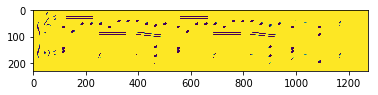

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

pixels = read_image('music1.png')

kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])

plt.imshow(conv2d(pixels, kernel))

In [44]:
#Using sobel kernels
sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

#Convolving the image
conv_img = conv2d(pixels, kernel_1)

#plt.imshow(conv_img)

print(pixels.shape)

(231, 1274)


In [74]:
#Creating an empty edge maps
T = []

#Iterating through the image
for i in conv_img:
    for j in i:
        
        #Checking if pixel value is 0 or not
        if(j == 0):
            T.append(0)
        else:
            T.append(1)
            
#Converting edge map to numpy array and reshaping it to the convolved image
T = np.array(T).reshape(conv_img.shape)

#Creating the other edge map
I = np.copy(T)

#Checking the shape of the edge maps
print(T.shape)
print(I.shape)

(231, 1274)
(231, 1274)


In [76]:
#Creating a function to calculate distance
def calc_dist(a, b, c, d):
    
    #Calculating distance
    dist = math.sqrt(abs(((a - c)*(a - c)) + ((b - d)*(b - d))))
    
    return dist

#Retrieving the number of rows and columns in the image
row, col = conv_img.shape

#Creating an array to store distances
D = []

#Iterating through the image pixels
for p in range(0,row):
    for q in range(0,col):
        
        #Creating a temporary array
        temp = []
        
        #Iterating through the edge pixels
        for i in range(0,row):
            for j in range(0,col):
                if(conv_img[i][j] != 0):
                    
                    #Calculating distance and storing it in temp
                    dist = calc_dist(p, q, i, j)
                    temp.append(dist)
                    
        #Converting the temporary array to a numpy array
        temp = np.array(temp)
        
        #Finding the smallest distance and storing it in D
        min_dist = np.min(temp)
        D.append(min_dist)
        
        print(p,q)
        
#Reshaping D to that of the image
D = np.array(D).reshape(conv_img.shape)